In [1]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)

✅ Style+Font ready: NanumGothic


# DAY 8 - Extension: 평일(Weekday) VS 주말(Weekend)

## 확인사항
Time-of-Day(0 ~ 23시) 축을 유지한 채, **요일 유형(평일/ 주말)**로 데이터를 분리해
전력 부하의 시간대 구조가 어떻게 달라지는지 확인한다.

## 분석 질문
1. 평일과 주말의 **시간대별 평균 부하 곡선**은 어떻게 다른가?
2. 평일 / 주말의 **피크 시간(peak hour)**과 **피크 부하(peak Load)**는 어떻게 다른가?
3. 평일 / 주말의 부하가 **특정 시간대에 더 집중**되는가? (Top-N 집중도)

## 산출물
- DAY8_weekday_weekend_hourly_profile.csv
  : 평일/주말 시간대별 평균 부하(0~23)

- DAY8_peak_info.csv
  : 평일/주말 피크 시간/피크 부하

- DAY8_peak_concentration.csv
  : Top-N(기본 3) 시간대 집중도

- DAY8_weekday_vs_weekend_profile.png 
  : 평일 vs 주말 시간대 곡선 비교
  
- (선택) DAY8_weekday_weekend_difference.png
  : (평일-주말) 차이 곡선

## 핵심 해석 포인트
- 총량이 비슷해도,  **피크가 언제  / 얼마나 집중되는 지**에 따라 운영 전략(ESS / DR 등)이 달라진다.
- DAY 1 에서 정의한 **Time-of-Day Baseline**을 유지하면서, 요일 변수만 추가해 "구조 차이"를 검증한다.

In [2]:
# 0) Path & Load
PROJECT_ROOT = Path.cwd().parent  # notebook/ 에서 실행한다고 가정
DATA_DIR = PROJECT_ROOT / "data"
OUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = PROJECT_ROOT / "figures"

OUT_DIR.mkdir(exist_ok = True)
FIG_DIR.mkdir(exist_ok =True)

RAW_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"

# encoding은 환경마다 다를 수 있어 utf-8-sig 먼저 시도
try:
    df = pd.read_csv(RAW_FILE, encoding = "utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(RAW_FILE, encoding ="cp949")

In [3]:
# USE_YM: YYYYMMDD 라고 가정
df["date"] = pd.to_datetime(df["USE_YM"], format = "%Y%m%d", errors = "coerce")

# USE_HM: HHMM
hour_raw = (df["USE_HM"] // 100).astype("Int64")

# 케이스 판별: 1~24면 -1 보정, 0~23이면 그대로
if hour_raw.min() >= 1 and hour_raw.max() <= 24:
    df["hour"] = hour_raw - 1
elif hour_raw.min() >= 0 and hour_raw.max() <= 23:
    df["hour"] = hour_raw
else:
    raise ValueError(f"USE_HM hour range 이상함: {hour_raw.min()}~{hour_raw.max()}")

assert df["hour"].between(0, 23).all()

# date + hour -> datetime
df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit = "h")

# month
df["month"] = df["datetime"].dt.month

# 전력값 컬럼을 프로젝트 공통명 value로 통일
df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"], errors = "coerce")

# 성공 체크
print("datetime 생성 성공률(%)", df["datetime"].notna().mean() * 100)
print("hour 범위:", df["hour"].min(), "~", df["hour"].max())
print("value 결측률(%):", df["value"].isna().mean() * 100)

df[["USE_YM", "USE_HM", "date", "hour", "datetime", "month", "value"]].head(10)


datetime 생성 성공률(%) 100.0
hour 범위: 0 ~ 23
value 결측률(%): 0.0


,USE_YM,USE_HM,date,hour,datetime,month,value
0,20220628,100,2022-06-28,0,2022-06-28,6,10782.0565
1,20220628,100,2022-06-28,0,2022-06-28,6,11394.8635
2,20220628,100,2022-06-28,0,2022-06-28,6,7273.9620
3,20220628,100,2022-06-28,0,2022-06-28,6,11008.8110
4,20220628,100,2022-06-28,0,2022-06-28,6,2905.1120
5,20220628,100,2022-06-28,0,2022-06-28,6,3416.9310
6,20220628,100,2022-06-28,0,2022-06-28,6,10473.6130
7,20220628,100,2022-06-28,0,2022-06-28,6,14196.5290
8,20220628,100,2022-06-28,0,2022-06-28,6,5894.3225
9,20220628,100,2022-06-28,0,2022-06-28,6,6393.6870


In [4]:
# 1. Datetime & Base columns
# 전제: DAY 1 ~ 7에서  "datetime" 컬럼이 존재하거나 생성한 상태
if "datetime" not in df.columns:
    raise KeyError("컬럼 'datetime'이 없습니다. DAY 1에서 만든 datetime 컬럼명을 확인")

df["datetime"] = pd.to_datetime(df["datetime"], errors = "coerce")
df = df.dropna(subset = ["datetime"]).copy()

# 전력 사용량 컬럼명 (value)
LOAD_COL ="value"
if LOAD_COL not in df.columns:
    raise KeyError(f"전력 사용량 컬럼'{LOAD_COL}'이 없습니다. 실제 컬럼명으로 LOAD_COL를 수정하세요.")

In [5]:
# 2. Weekday / Weekend Labeling
df["hour"] = df["datetime"].dt.hour
df["dow"] = df["datetime"].dt.dayofweek # mon = 0 ~ sun = 6
df["day_type"] = np.where(df["dow"] < 5, "Weekday", "Weekend")

# sanity check
print("Rows:", len(df))
print(df[["datetime", "hour", "dow", "day_type", LOAD_COL]].head())

Rows: 9754804
    datetime  hour  dow day_type       value
0 2022-06-28     0    1  Weekday  10782.0565
1 2022-06-28     0    1  Weekday  11394.8635
2 2022-06-28     0    1  Weekday   7273.9620
3 2022-06-28     0    1  Weekday  11008.8110
4 2022-06-28     0    1  Weekday   2905.1120


In [6]:
# 3) Hourly Mean Profile (core table)
day8_profile = (df.groupby(["day_type", "hour"], as_index = False)[LOAD_COL].mean().rename(columns = {LOAD_COL: "load_mean"}))
day8_pivot = (day8_profile.pivot(index = "hour", columns = "day_type", values = "load_mean").sort_index())

print("===[DAY8 Pivot head]===")
print(day8_pivot.head())

# PV overlap index (DAY8에 추가 추천)
pv_hours = list(range(10, 16))       # PV 가용 시간(이론) 예시
evening_hours = list(range(18, 22))  # 18~21

def share_in_hours(pivot, col, hours):
    return pivot.loc[hours, col].sum() / pivot[col].sum()

weekday_evening_share = share_in_hours(day8_pivot, "Weekday", evening_hours)
weekend_evening_share = share_in_hours(day8_pivot, "Weekend", evening_hours)
weekday_pv_overlap = share_in_hours(day8_pivot, "Weekday", pv_hours)
weekend_pv_overlap = share_in_hours(day8_pivot, "Weekend", pv_hours)

pd.DataFrame({
    "Evening share (18-21)": [weekday_evening_share, weekend_evening_share],
    "PV overlap share (10-15)": [weekday_pv_overlap, weekend_pv_overlap],
}, index=["Weekday", "Weekend"])

===[DAY8 Pivot head]===
day_type      Weekday      Weekend
hour                              
0         4895.592029  4656.166312
1         4480.701693  4320.281276
2         4371.542724  4121.373858
3         4126.924098  3919.382481
4         4615.220943  4086.001891


,Evening share (18-21),PV overlap share (10-15)
Weekday,0.176891,0.310520
Weekend,0.184778,0.282914


In [7]:
# 4. Metric 1 : Peak hour & peak load
peak_info = (day8_profile.sort_values(["day_type", "load_mean"], ascending = [True, False])
             .groupby("day_type", as_index = False).first().rename(columns = {"hour": "peak_hour", "load_mean": "peak_load"}))

print("===[Peak info]===")
print(peak_info)

===[Peak info]===
  day_type  peak_hour    peak_load
0  Weekday         13  8288.850746
1  Weekend         18  6022.515349


In [8]:
# 5. Metric 2: Peak concentration ( TOP -N share)
TOP_N = 3
rows = []
for day_type, g in day8_profile.groupby("day_type"):
    g_sorted = g.sort_values("load_mean", ascending = False)
    top_sum = g_sorted.head(TOP_N)["load_mean"].sum()
    total_sum = g_sorted["load_mean"].sum()

    rows.append({
        "day_type": day_type,
        "topN": TOP_N,
        "topN_share": float(top_sum / total_sum) if total_sum else np.nan})
    
concentration = pd.DataFrame(rows)

print("===[TOP-N concentration]===")
print(concentration)

===[TOP-N concentration]===
  day_type  topN  topN_share
0  Weekday     3    0.156811
1  Weekend     3    0.143930


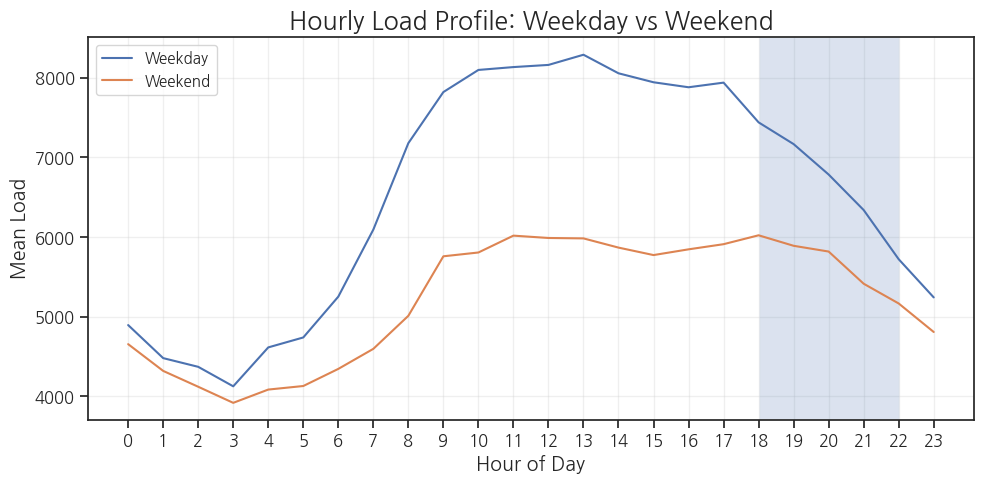

In [9]:
# 6. Plot 1: Weekday VS Weekend Profile (required)

# day8_pivot 에 두 컬럼이 모두 있는지 체크
required_cols = {"Weekday", "Weekend"}
missing = required_cols - set(day8_pivot.columns)
if missing:
    raise ValueError(f"day8_pivot에 {missing} 컬럼이 없습니다. day_type 생성 / 데이터 범위를 확인하세요.")

plt.figure(figsize = (10, 5))
plt.plot(day8_pivot.index, day8_pivot["Weekday"], label="Weekday")
plt.plot(day8_pivot.index, day8_pivot["Weekend"], label = "Weekend")

plt.title("Hourly Load Profile: Weekday vs Weekend")
plt.xticks(range(0 ,24, 1))
plt.axvspan(18, 22, alpha=0.2)
plt.xlabel("Hour of Day")
plt.ylabel("Mean Load")
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()

plt.savefig(FIG_DIR / "DAY8_weekday_vs_weekend_profile.png", dpi = 300)
plt.show()

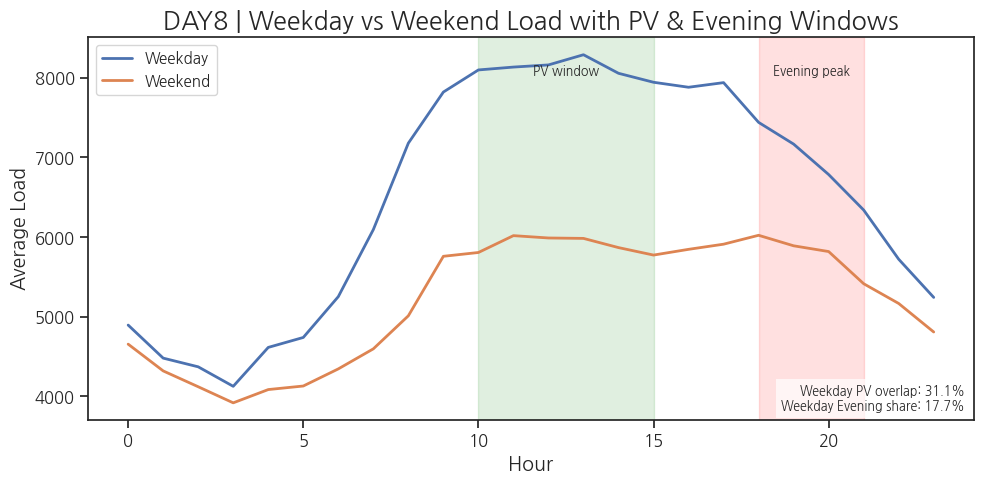

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(day8_pivot.index, day8_pivot["Weekday"], label="Weekday", lw=2)
ax.plot(day8_pivot.index, day8_pivot["Weekend"], label="Weekend", lw=2)

# PV 시간대 (10~15), (18~21)
ax.axvspan(10, 15, color="green", alpha=0.12)
ax.axvspan(18, 21, color="red", alpha=0.12)

ax.text(12.5, ax.get_ylim()[1]*0.95, "PV window", ha="center", va="center", fontsize=9)
ax.text(19.5, ax.get_ylim()[1]*0.95, "Evening peak", ha="center", va="center", fontsize=9)

ax.set_xlabel("Hour")
ax.set_ylabel("Average Load")
ax.legend()
ax.set_title("DAY8 | Weekday vs Weekend Load with PV & Evening Windows")
ax.text(
    0.99, 0.02,
    f"Weekday PV overlap: {weekday_pv_overlap:.1%}\n"
    f"Weekday Evening share: {weekday_evening_share:.1%}",
    transform=ax.transAxes,
    fontsize=9,
    va="bottom",
    ha="right",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

plt.tight_layout()
plt.show()

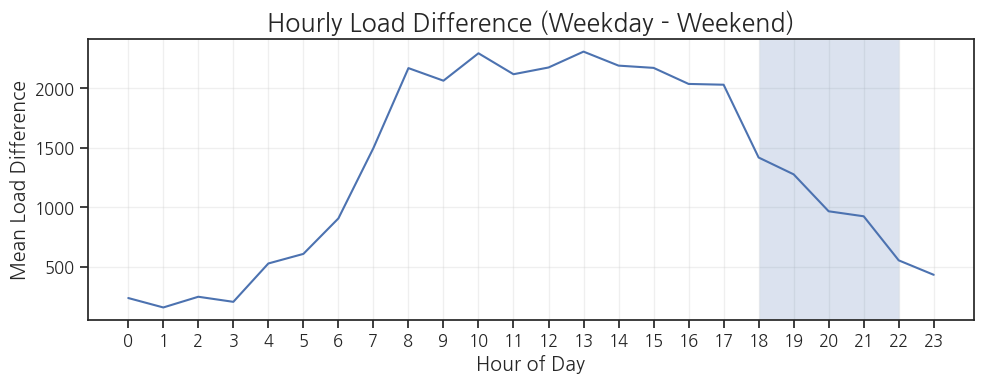

In [11]:
# 7. plot 2: Difference curve (optional)
diff = day8_pivot["Weekday"] - day8_pivot["Weekend"]

plt.figure(figsize = (10, 4))
plt.plot(diff.index, diff.values)

plt.title("Hourly Load Difference (Weekday - Weekend)")
plt.xticks(range(0, 24, 1))
plt.axvspan(18, 22, alpha=0.2)
plt.xlabel("Hour of Day")
plt.ylabel("Mean Load Difference")
plt.grid(alpha = 0.3)
plt.tight_layout()

plt.savefig(FIG_DIR / "DAY8_weekday_weekend_difference.png", dpi = 300)

In [12]:
# 8. Save outputs (csv)
day8_pivot.to_csv(OUT_DIR / "DAY8_weekday_weekend_hourly_profile.csv", encoding = "utf-8-sig")
peak_info.to_csv(OUT_DIR / "DAY8_peak_info.csv", encoding = "utf-8-sig", index = False)
concentration.to_csv(OUT_DIR / "DAY8_peak_concentration.csv", encoding = "utf-8-sig", index = False)

print("===Saved===")
print(" -", OUT_DIR / "DAY8_weekday_weekend_hourly_profile.csv")
print(" -", OUT_DIR / "DAY8_peak_info.csv")
print(" -", OUT_DIR / "DAY8_peak_concentration.csv")
print(" -", FIG_DIR / "DAY8_weekday_vs_weekend_profile.png")
print(" -", FIG_DIR / "DAY8_weekday_weekend_difference.png")

===Saved===
 - e:\Portfolio_ver1\seoul_pv_load_analysis\outputs\DAY8_weekday_weekend_hourly_profile.csv
 - e:\Portfolio_ver1\seoul_pv_load_analysis\outputs\DAY8_peak_info.csv
 - e:\Portfolio_ver1\seoul_pv_load_analysis\outputs\DAY8_peak_concentration.csv
 - e:\Portfolio_ver1\seoul_pv_load_analysis\figures\DAY8_weekday_vs_weekend_profile.png
 - e:\Portfolio_ver1\seoul_pv_load_analysis\figures\DAY8_weekday_weekend_difference.png


In [13]:
# 9. DAY 8 - Conclusion
def day8_conclusion_print(peak_info, concentration, day8_pivot):
    print("===DAY 8 결론: 평일 VS 주말===\n")

    # 1) Peak comparison
    print("[피크 시간대 비교]")
    for _, r in peak_info.iterrows():
        print(f"-{r['day_type']}: 피크 시간 = {int(r['peak_hour'])}h, 피크 부하 = {r['peak_load']}")
    
    print()

    # 2) Concentration
    print("[피크 집중도 (TOP 시간대 비중)]")
    for _, r in concentration.iterrows():
        print(f"- {r['day_type']}: TOP-{int(r['topN'])} hours share = {r['topN_share'] * 100:.1f}%")

print("\n===[해석]===")
print("- 평일은 특정 시간대(특히 저녁)에 전력 부하가 더 집중되는 구조를 보인다.")
print("- 주말은 상대적으로 부하가 분산되어 태양광 발전 시간대와의  겹침 가능성이 높다.")
print("- 이는 태양광의 한계가 발전량 자체가 아니라, 평일 저녁 피크와의 시간대 구조적 불일치에서 발생함을 의미한다.")
print("- 본 분석은 DAY 1 에서 설정한 Time-of-Day 관점을 요일 구분을 통해 구조적으로 검증한 단계이다.")

# 10. 보조 수치 (저녁 피크 차이)
if {"Weekday", "Weekend"}.issubset(day8_pivot.columns):
    diff_evening = day8_pivot.loc[18:21, "Weekday"].mean() - day8_pivot.loc[18:21, "Weekend"].mean()
    print(f"\n===[참고 지표]===")
    print(f" - 저녁 시간대 (18 ~ 21시) 평균 부하 차이 (평일 - 주말) = {diff_evening:.2f}")

# 실행
day8_conclusion_print(peak_info, concentration, day8_pivot)


===[해석]===
- 평일은 특정 시간대(특히 저녁)에 전력 부하가 더 집중되는 구조를 보인다.
- 주말은 상대적으로 부하가 분산되어 태양광 발전 시간대와의  겹침 가능성이 높다.
- 이는 태양광의 한계가 발전량 자체가 아니라, 평일 저녁 피크와의 시간대 구조적 불일치에서 발생함을 의미한다.
- 본 분석은 DAY 1 에서 설정한 Time-of-Day 관점을 요일 구분을 통해 구조적으로 검증한 단계이다.

===[참고 지표]===
 - 저녁 시간대 (18 ~ 21시) 평균 부하 차이 (평일 - 주말) = 1146.37
===DAY 8 결론: 평일 VS 주말===

[피크 시간대 비교]
-Weekday: 피크 시간 = 13h, 피크 부하 = 8288.850746037342
-Weekend: 피크 시간 = 18h, 피크 부하 = 6022.515348780939

[피크 집중도 (TOP 시간대 비중)]
- Weekday: TOP-3 hours share = 15.7%
- Weekend: TOP-3 hours share = 14.4%
